In [1]:
# Download kaggle pip package so we can download the
# Flickr8K dataset via Kaggle API.
!pip -q install kaggle

**IMPORTING ESSENTIAL LIBRARIES**

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
# IMPORTS

import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import requests
import time
from PIL import Image
from tqdm.auto import tqdm

In [4]:
COLAB = os.path.exists('/content/')

if COLAB:
    BASE_DIR = '/content'
else:
    BASE_DIR = '.'

**DOWNLOADED THE DATA SET FROM THE KAGGLE USING API KEY**

In [5]:
# Download Flickr8K dataset

if not os.path.exists(f'{BASE_DIR}/data/'):
    
    # Enter your kaggle credentials
    api_token = {"username": "farhan79",
                 "key": "96b5e99aba0f7c20a92051f41deced83"}

    with open(f'{BASE_DIR}/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = BASE_DIR
    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs(f'{BASE_DIR}/data/', exist_ok=True)
    os.system(f'mv {BASE_DIR}/flickr8k.zip {BASE_DIR}/data/flickr8k.zip')
    os.system(f'unzip -q {BASE_DIR}/data/flickr8k.zip -d {BASE_DIR}/data/')
    os.remove(f'{BASE_DIR}/data/flickr8k.zip')

In [6]:
# load the captions.txt with pandas
captions = pd.read_csv(f'{BASE_DIR}/data/captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
print('Dataset shape:', captions.shape)

Dataset shape: (40455, 2)


In [8]:
# Because the image column just contains the image name, let's enter
# the complete path of the image so we can easily access it.
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_DIR}/data/Images/{x}')

**EXTRACTED IMAGE FEATURES USING PRE TRAINED MODEL**

In [9]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [10]:
# extract features from image
features = {}
directory = r'/content/data/Images'

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [11]:
WORKING_DIR = '/content/data/working'

In [12]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [13]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

**LOADED THE CAPTIONS DATA**

In [14]:
with open(os.path.join('/content/data/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [15]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [16]:
len(mapping)

8091

**PRE PROCESSED THE TEXT DATA**

In [17]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
          # take one caption at a time
          caption = captions[i]
          # preprocessing steps
          # convert to lowercase
          caption = caption.lower()
          # delete digits, special chars, etc., 
          caption = caption.replace('[^A-Za-z]', '')
          # delete additional spaces
          caption = caption.replace('\s+', ' ')
          # add start and end tags to the caption
          caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
          captions[i] = caption

In [18]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
# preprocess the text
clean(mapping)

In [20]:
# after preprocess of text
mapping['1002674143_1b742ab4b8']

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

In [21]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [22]:
len(all_captions)

40455

In [23]:
all_captions[5:10]

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [25]:
vocab_size

8485

In [26]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

**TRAIN TEST SPLIT**

In [27]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [28]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], 
          num_classes=vocab_size)[0]
          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
          if n == batch_size:
            X1, X2, y = np.array(X1), np.array(X2), np.array(y)
            yield [X1, X2], y
            X1, X2, y = list(), list(), list()
            n = 0

**MODEL DECLARATION**

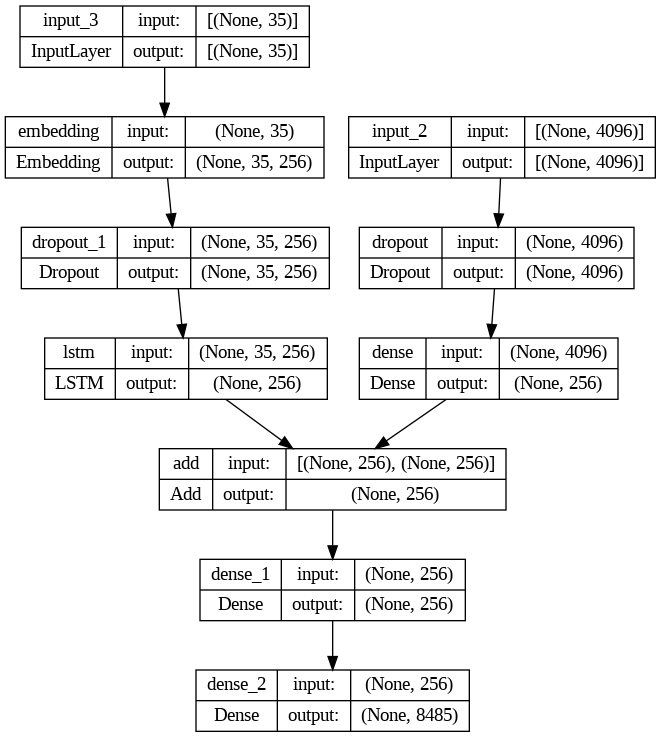

In [29]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [30]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 61s 269ms/step - loss: 2.1721


In [38]:
# save the model
model.save(WORKING_DIR+'/model_file.h5')

**Generate Captions for the Image**

In [39]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [40]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

**EVALUATION ON TEST DATA**

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

**VISUALISING THE RESULTS**

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/data', "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq cluster of four brown dogs play in field of brown grass endseq
startseq four dogs are together in the field of dry grass endseq
startseq four dogs in grassy area endseq
startseq four medium-sized dogs wrestle with each other on grass field endseq
startseq four small dogs play outside endseq
--------------------Predicted--------------------
startseq two dogs are playing together in the grass endseq


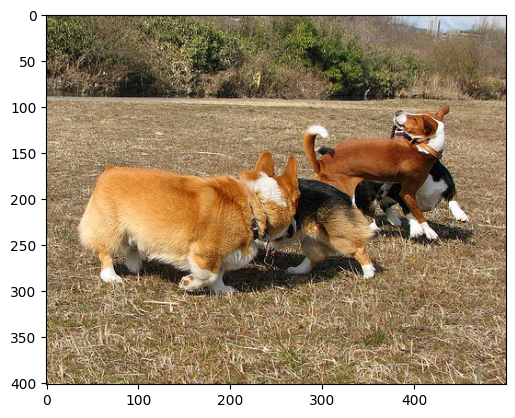

In [44]:
generate_caption(f'{test[10]}.jpg')

---------------------Actual---------------------
startseq "people possibly fishermen with their boats in shadow on shore at an orangesunset" endseq
startseq man in an orange vest is standing next to yellow canoe endseq
startseq people tend canoes at the edge of body of water during dimly lit time of day endseq
startseq the men are getting their kayaks secured on the beach for the night endseq
startseq two men standing on the shore beside their kayaks at dusk endseq
--------------------Predicted--------------------
startseq man is snowboarding on the tops of snow 's edge endseq


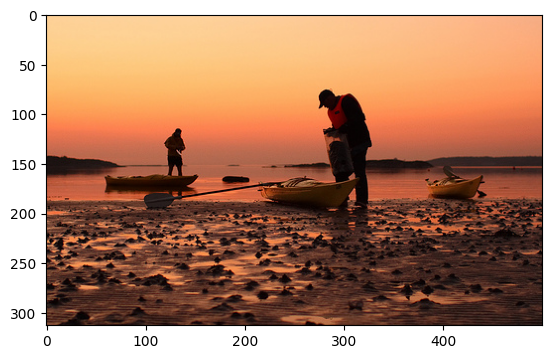

In [46]:
generate_caption(f'{test[9]}.jpg')

---------------------Actual---------------------
startseq caravan of snowmobile travel through the snow endseq
startseq pair of people in heavy winter jackets rides through the snow on snowmobile endseq
startseq people riding something in the snow endseq
startseq person on polaris ski mobile in the snow endseq
startseq the man wearing blue helmet is riding polaris endseq
--------------------Predicted--------------------
startseq child in red coat is riding red plastic kitty ladder endseq


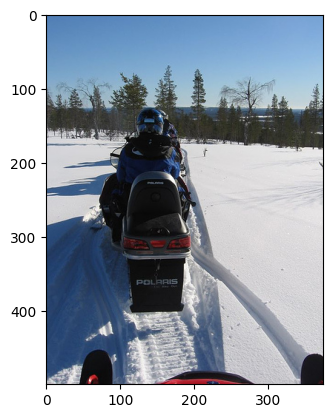

In [48]:
generate_caption(f'{test[5]}.jpg')

---------------------Actual---------------------
startseq female toddler wearing pink shirt is playing on playground endseq
startseq little girl in pink and purple stands on playground endseq
startseq very young girl is walking on playground endseq
startseq the little girl is playing at the playground endseq
startseq young child in pink top and purple pants clutching turquoise guard rail endseq
--------------------Predicted--------------------
startseq little boy in red shirt is on playground equipment endseq


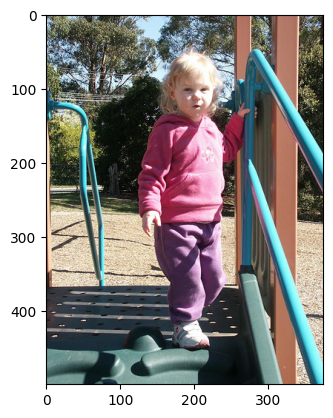

In [49]:
generate_caption(f'{test[50]}.jpg')

---------------------Actual---------------------
startseq black and brown dog walks through the snow near building endseq
startseq "a black dog running in the snow ." endseq
startseq black dog running in the snow by some trees endseq
startseq large black and tan dog is running across the snow in wooded area endseq
startseq the black and brown dog is running through the snow endseq
--------------------Predicted--------------------
startseq black dog is running through snow covered snow endseq


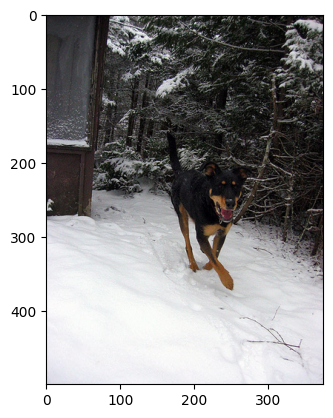

In [54]:
generate_caption(f'{test[34]}.jpg')